In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import torch
import matplotlib.pyplot as plt

### Load Data

In [2]:
data_train = pd.read_csv('Google_Stock_Price_Train.csv.xls', thousands=',')
data_train.shape

(1258, 6)

In [3]:
data_test = pd.read_csv('Google_Stock_Price_Test.csv.xls',thousands=',')
data_test

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,1657300
1,1/4/2017,788.36,791.34,783.16,786.90,1073000
2,1/5/2017,786.08,794.48,785.02,794.02,1335200
3,1/6/2017,795.26,807.90,792.20,806.15,1640200
4,1/9/2017,806.40,809.97,802.83,806.65,1272400
5,1/10/2017,807.86,809.13,803.51,804.79,1176800
6,1/11/2017,805.00,808.15,801.37,807.91,1065900
7,1/12/2017,807.14,807.39,799.17,806.36,1353100
8,1/13/2017,807.48,811.22,806.69,807.88,1099200
9,1/17/2017,807.08,807.14,800.37,804.61,1362100


In [4]:
data = pd.concat([data_train,data_test], axis=0 )
data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,7380500
1,1/4/2012,331.27,333.87,329.08,666.45,5749400
2,1/5/2012,329.83,330.75,326.89,657.21,6590300
3,1/6/2012,328.34,328.77,323.68,648.24,5405900
4,1/9/2012,322.04,322.29,309.46,620.76,11688800
...,...,...,...,...,...,...
15,1/25/2017,829.62,835.77,825.06,835.67,1494500
16,1/26/2017,837.81,838.00,827.01,832.15,2973900
17,1/27/2017,834.71,841.95,820.44,823.31,2965800
18,1/30/2017,814.66,815.84,799.80,802.32,3246600


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
data = data.iloc[:,1:]
data

,Open,High,Low,Close,Volume
0,325.25,332.83,324.97,663.59,7380500
1,331.27,333.87,329.08,666.45,5749400
2,329.83,330.75,326.89,657.21,6590300
3,328.34,328.77,323.68,648.24,5405900
4,322.04,322.29,309.46,620.76,11688800
...,...,...,...,...,...
15,829.62,835.77,825.06,835.67,1494500
16,837.81,838.00,827.01,832.15,2973900
17,834.71,841.95,820.44,823.31,2965800
18,814.66,815.84,799.80,802.32,3246600


In [6]:
data_scaled = scaler.fit_transform(data)
data_scaled.shape

(1278, 5)

In [7]:
def split_data(stock, lookback): 
    data = []

    for i in range(len(stock) - lookback): 
        data.append(stock[i: i + lookback])
    
    data = np.array(data);
    val_set_size = int(np.round(0.2*data_train.shape[0]));
    train_set_size = data_train.shape[0] - (val_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_val = data[train_set_size:,:-1]
    y_val = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val]

In [8]:
lookback = 5
x_train, y_train, x_val, y_val = split_data(data_scaled, lookback)

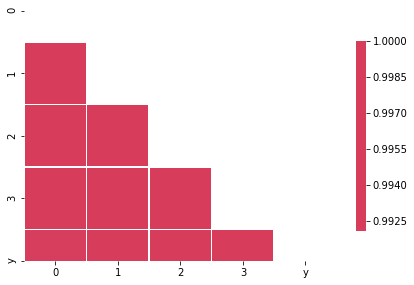

In [9]:
#create training dataframe to check correlation
df_y = pd.DataFrame(y_train[:,0],columns = ['y'])
df_x = pd.DataFrame(x_train[:,:,0])
df = pd.concat([df_x, df_y], axis=1)

corr_matrix_1 = df.corr()
f, ax = plt.subplots(figsize=(7, 7))
cmap = sns.diverging_palette(240, 5, as_cmap=True)
mask = np.triu(np.ones_like(corr_matrix_1, dtype=np.bool))
sns.heatmap(corr_matrix_1, mask= mask, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

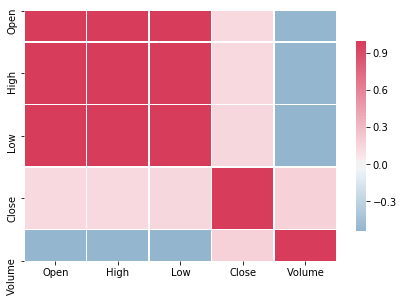

In [10]:
corr_matrix = data.corr()
f, ax = plt.subplots(figsize=(7, 7))
cmap = sns.diverging_palette(240, 5, as_cmap=True)
sns.heatmap(corr_matrix, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)

y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_val_lstm = torch.from_numpy(y_val).type(torch.Tensor)

y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_val_gru = torch.from_numpy(y_val).type(torch.Tensor)

y_train_rnn = torch.from_numpy(y_train).type(torch.Tensor)
y_val_rnn = torch.from_numpy(y_val).type(torch.Tensor)


#### Test data preprocessing

In [12]:
lookback = 5

def split_test(stock, lookback): 
    data = []

    for i in range(len(stock) - lookback): 
        data.append(stock[i: i + lookback])
    
    data = np.array(data);
    
    x_test = data[1253:,:-1,:]
    y_test = data[1253:,-1,:]
    
    return [x_test, y_test]

x_test, y_test = split_test(data_scaled, lookback)


In [13]:
x_test = torch.from_numpy(x_test).type(torch.Tensor)

y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)
y_test_rnn = torch.from_numpy(y_test).type(torch.Tensor)

x_test.shape

torch.Size([20, 4, 5])

### LSTM

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [15]:
input_dim = 5
hidden_dim = 128
num_layers = 1
output_dim = 5
num_epochs = 200

In [16]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [17]:
import time
start_time = time.time()

hist = np.zeros(num_epochs)
lstm = []
for t in range(num_epochs):
    y_train_pred_lstm = model(x_train)
    loss = criterion(y_train_pred_lstm, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
lstm_training_time = time.time()-start_time
print("Training time: {}".format(lstm_training_time))

Epoch  0 MSE:  0.3586135506629944
Epoch  1 MSE:  0.24842007458209991
Epoch  2 MSE:  0.14304624497890472
Epoch  3 MSE:  0.09373142570257187
Epoch  4 MSE:  0.0691278800368309
Epoch  5 MSE:  0.0399477481842041
Epoch  6 MSE:  0.046885404735803604
Epoch  7 MSE:  0.051524173468351364
Epoch  8 MSE:  0.03946517035365105
Epoch  9 MSE:  0.024857673794031143
Epoch  10 MSE:  0.015267789363861084
Epoch  11 MSE:  0.0149487080052495
Epoch  12 MSE:  0.01800575666129589
Epoch  13 MSE:  0.021602561697363853
Epoch  14 MSE:  0.023795640096068382
Epoch  15 MSE:  0.01699722185730934
Epoch  16 MSE:  0.010615705512464046
Epoch  17 MSE:  0.009266287088394165
Epoch  18 MSE:  0.010468076914548874
Epoch  19 MSE:  0.011949771083891392
Epoch  20 MSE:  0.013035252690315247
Epoch  21 MSE:  0.013487758114933968
Epoch  22 MSE:  0.013047485612332821
Epoch  23 MSE:  0.01171936560422182
Epoch  24 MSE:  0.010031834244728088
Epoch  25 MSE:  0.008821346797049046
Epoch  26 MSE:  0.008493280969560146
Epoch  27 MSE:  0.00855243

In [18]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred_lstm.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

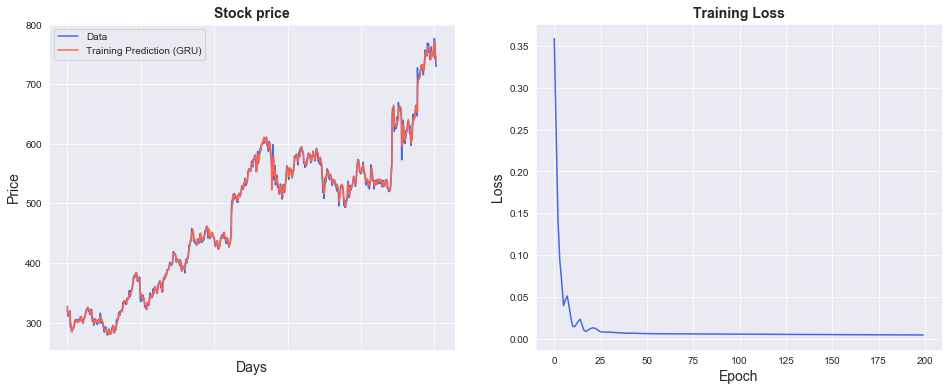

In [19]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [20]:
# make predictions with validation set
y_val_pred_lstm = model(x_val)
y_val_pred_lstm

#invert predictions
y_train_pred_lstm = scaler.inverse_transform(y_train_pred_lstm.detach().numpy())
y_train_lstm = scaler.inverse_transform(y_train_lstm.detach().numpy())

y_val_pred_lstm = scaler.inverse_transform(y_val_pred_lstm.detach().numpy())
y_val_lstm = scaler.inverse_transform(y_val_lstm.detach().numpy())

In [21]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
import math

lstm_train_error_list = [] 
for i in range(5):
    train_error_lstm  = math.sqrt(mean_squared_error(y_train_lstm[:,i], y_train_pred_lstm[:,i]))
    lstm_train_error_list.append(train_error_lstm)
    
lstm_val_error_list = []    
for i in range(5):
    val_error_lstm  = math.sqrt(mean_squared_error(y_val_lstm[:,i], y_val_pred_lstm[:,i]))
    lstm_val_error_list.append(val_error_lstm)

In [22]:
print(lstm_train_error_list)
print(lstm_val_error_list)

[7.279555225828613, 8.158247312170854, 8.13438929389111, 22.22650757901826, 1716789.7492331436]
[8.494970741154228, 9.006976073075638, 10.643839212022451, 10.543670303052568, 762991.9273596543]


In [23]:
# make predictions with test set
y_test_pred_lstm = model(x_test)

# invert predictions
y_test_pred_lstm = scaler.inverse_transform(y_test_pred_lstm.detach().numpy())
y_test_lstm = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
lstm_test_error_list = []
for i in range(5):
    test_error_lstm  = math.sqrt(mean_squared_error(y_test_lstm[:,i], y_test_pred_lstm[:,i]))
    lstm_test_error_list.append(test_error_lstm)
    
print(lstm_test_error_list)
print(y_test_pred_lstm)

[6.905783520992991, 8.215698139711048, 9.267185227775391, 10.334635334640502, 619399.8693445132]
[[7.8561414e+02 7.9392163e+02 7.7895508e+02 7.8046271e+02 1.7023860e+06]
 [7.8056964e+02 7.8823035e+02 7.7342444e+02 7.7242499e+02 1.8656920e+06]
 [7.8151337e+02 7.8933575e+02 7.7440808e+02 7.7879474e+02 1.9440146e+06]
 [7.8513171e+02 7.9361206e+02 7.7868317e+02 7.8492078e+02 1.8322300e+06]
 [7.8872968e+02 7.9714832e+02 7.8214185e+02 7.9222156e+02 1.8557515e+06]
 [7.9634296e+02 8.0507672e+02 7.8981549e+02 8.0297443e+02 1.8941020e+06]
 [8.0313251e+02 8.1224915e+02 7.9705896e+02 8.0853882e+02 1.8438441e+06]
 [8.0584473e+02 8.1491968e+02 7.9978174e+02 8.0736481e+02 1.8157720e+06]
 [8.0575806e+02 8.1460559e+02 7.9950464e+02 8.0522247e+02 1.8192086e+06]
 [8.0528119e+02 8.1389197e+02 7.9883508e+02 8.0408429e+02 1.8627764e+06]
 [8.0706647e+02 8.1603815e+02 8.0090796e+02 8.0568951e+02 1.8125512e+06]
 [8.0598120e+02 8.1462830e+02 7.9956671e+02 8.0419531e+02 1.8586165e+06]
 [8.0506036e+02 8.1363678e+

In [24]:
Error_test_pct_list_lstm = []

for i in range(5):
    Error_test_pct_lstm = abs(y_test_lstm[:,i] - y_test_pred_lstm[:,i])
    Error_test_pct_lstm = np.mean(Error_test_pct_lstm)
    Error_test_pct_lstm = Error_test_pct_lstm/(y_test_pred_lstm[:,i].mean())
    Error_test_pct_list_lstm.append(Error_test_pct_lstm)

print('LSTM test - (MAPE):', Error_test_pct_list_lstm)     

LSTM test - (MAPE): [0.0060276305, 0.007881505, 0.008981394, 0.009724872, 0.28751588]


### GRU

In [25]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [26]:
input_dim = 5
hidden_dim = 128
num_layers = 1
output_dim = 5
num_epochs = 200

In [27]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [28]:
start_time = time.time()

hist = np.zeros(num_epochs)

for t in range(num_epochs):
    y_train_pred_gru = model(x_train)

    loss = criterion(y_train_pred_gru, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
gru_training_time = time.time()-start_time    
print("GRU_Training time: {}".format(gru_training_time))

Epoch  0 MSE:  0.3542473316192627
Epoch  1 MSE:  0.1744200438261032
Epoch  2 MSE:  0.08201440423727036
Epoch  3 MSE:  0.10915770381689072
Epoch  4 MSE:  0.03493620455265045
Epoch  5 MSE:  0.0428951270878315
Epoch  6 MSE:  0.054944757372140884
Epoch  7 MSE:  0.04630440101027489
Epoch  8 MSE:  0.026309555396437645
Epoch  9 MSE:  0.013602009043097496
Epoch  10 MSE:  0.012834484688937664
Epoch  11 MSE:  0.018891315907239914
Epoch  12 MSE:  0.023072771728038788
Epoch  13 MSE:  0.022391974925994873
Epoch  14 MSE:  0.0180799663066864
Epoch  15 MSE:  0.01263856515288353
Epoch  16 MSE:  0.009207209572196007
Epoch  17 MSE:  0.009003094397485256
Epoch  18 MSE:  0.010684797540307045
Epoch  19 MSE:  0.012129323557019234
Epoch  20 MSE:  0.0122741824015975
Epoch  21 MSE:  0.011372990906238556
Epoch  22 MSE:  0.010167301632463932
Epoch  23 MSE:  0.009210077114403248
Epoch  24 MSE:  0.008699865080416203
Epoch  25 MSE:  0.008573545143008232
Epoch  26 MSE:  0.008634156547486782
Epoch  27 MSE:  0.00865803

In [29]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred_gru.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

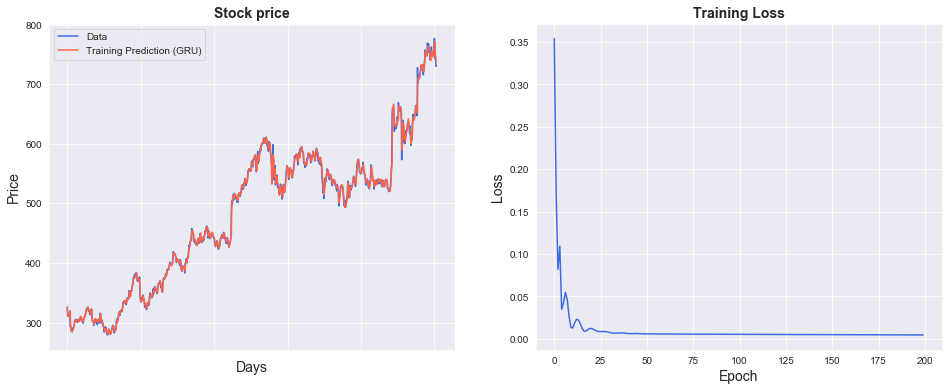

In [30]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [31]:
# make predictions
y_val_pred_gru = model(x_val)

In [32]:
# invert predictions

y_train_pred_gru = scaler.inverse_transform(y_train_pred_gru.detach().numpy())
y_train_gru = scaler.inverse_transform(y_train_gru.detach().numpy())

y_val_pred_gru = scaler.inverse_transform(y_val_pred_gru.detach().numpy())
y_val_gru = scaler.inverse_transform(y_val_gru.detach().numpy())


In [33]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
import math

gru_train_error_list = [] 
for i in range(5):
    train_error_gru = (np.square(y_train_gru[:,i]-y_train_pred_gru[:,i])).mean()
    train_error_gru = np.sqrt(train_error_gru)
    gru_train_error_list.append(train_error_gru)

gru_val_error_list = []    
for i in range(5):
    val_error_gru = (np.square(y_val_gru[:,i]-y_val_pred_gru[:,i])).mean()
    val_error_gru = np.sqrt(val_error_gru)
    gru_val_error_list.append(val_error_gru)


In [34]:
print(gru_train_error_list)
print(gru_val_error_list)

[6.6450195, 7.5928392, 7.4357715, 21.342194, 1652218.5]
[8.106436, 8.538923, 10.4607, 9.862525, 705561.75]


In [35]:
# make predictions
y_test_pred_gru = model(x_test)

In [36]:
y_test_pred_gru = y_test_pred_gru.detach().numpy()
y_test_pred_gru = scaler.inverse_transform(y_test_pred_gru)


In [37]:
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [38]:
y_test_gru = y_test_gru.detach().numpy()
y_test_gru = scaler.inverse_transform(y_test_gru)


In [39]:
gru_test_error_list = []
for i in range(5):
    data_list = ['open', 'high', 'low', 'close', 'volume']
    test_error_gru = (np.square(y_test_gru[:,i]-y_test_pred_gru[:,i])).mean()
    test_error_gru = np.sqrt(test_error_gru)
    gru_test_error_list.append(test_error_gru)
    
print(gru_test_error_list)
print(y_test_gru)

[7.584349, 7.907361, 11.036224, 8.755388, 567963.25]
[[7.8275000e+02 7.8278003e+02 7.7041003e+02 7.7182001e+02 1.7700000e+06]
 [7.7881000e+02 7.8963000e+02 7.7579999e+02 7.8614001e+02 1.6573001e+06]
 [7.8836005e+02 7.9133997e+02 7.8315997e+02 7.8690002e+02 1.0730004e+06]
 [7.8608002e+02 7.9447998e+02 7.8502002e+02 7.9402002e+02 1.3351999e+06]
 [7.9526001e+02 8.0789996e+02 7.9220001e+02 8.0614996e+02 1.6402000e+06]
 [8.0639996e+02 8.0996997e+02 8.0283002e+02 8.0665002e+02 1.2723999e+06]
 [8.0785999e+02 8.0913000e+02 8.0351001e+02 8.0478998e+02 1.1768001e+06]
 [8.0500000e+02 8.0815002e+02 8.0137000e+02 8.0791003e+02 1.0659004e+06]
 [8.0713995e+02 8.0739001e+02 7.9916998e+02 8.0635999e+02 1.3531000e+06]
 [8.0747998e+02 8.1122003e+02 8.0669000e+02 8.0788000e+02 1.0992001e+06]
 [8.0707996e+02 8.0714001e+02 8.0037000e+02 8.0460999e+02 1.3620999e+06]
 [8.0581000e+02 8.0621002e+02 8.0098999e+02 8.0606995e+02 1.2944004e+06]
 [8.0512000e+02 8.0948004e+02 8.0179999e+02 8.0217004e+02 9.1930000e+05

In [40]:
Error_train_pct_list = []

for i in range(5):
    Error_train_pct_gru = abs(y_train_gru[:,i] - y_train_pred_gru[:,i])
    Error_train_pct_gru = np.mean(Error_train_pct_gru)
    Error_train_pct_gru = Error_train_pct_gru/(y_train_pred_gru[:,i].mean())
    Error_train_pct_list.append(Error_train_pct_gru)
    
print('GRU Train -(MAPE):', Error_train_pct_list)        

GRU Train -(MAPE): [0.007839069, 0.009564306, 0.009726424, 0.0118703535, 0.26222077]


In [41]:
Error_val_pct_list = []

for i in range(5):
    Error_val_pct_gru = abs(y_val_gru[:,i] - y_val_pred_gru[:,i])
    Error_val_pct_gru = np.mean(Error_val_pct_gru)
    Error_val_pct_gru = Error_val_pct_gru/(y_val_pred_gru[:,i].mean())
    Error_val_pct_list.append(Error_val_pct_gru)

print('GRU val - (MAPE):', Error_val_pct_list)        

GRU val - (MAPE): [0.0077273613, 0.008392158, 0.011061339, 0.009647308, 0.26969212]


In [42]:
Error_test_pct_list = []

for i in range(5):
    Error_test_pct_gru = abs(y_test_gru[:,i] - y_test_pred_gru[:,i])
    Error_test_pct_gru = np.mean(Error_test_pct_gru)
    Error_test_pct_gru = Error_test_pct_gru/(y_test_pred_gru[:,i].mean())
    Error_test_pct_list.append(Error_test_pct_gru)

print('GRU test - (MAPE):', Error_test_pct_list)     

GRU test - (MAPE): [0.007481212, 0.0077398177, 0.012441237, 0.007986582, 0.26695582]


### Tanh (Vanilla) RNN

In [43]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.RNN = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.RNN(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [44]:
input_dim = 5
hidden_dim = 128
num_layers = 1
output_dim = 5
num_epochs = 200

In [45]:
model = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [46]:
start_time = time.time()

hist = np.zeros(num_epochs)
rnn = []

for t in range(num_epochs):
    y_train_pred_rnn = model(x_train)

    loss = criterion(y_train_pred_rnn, y_train_rnn)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
rnn_training_time = time.time()-start_time    
print("Training time: {}".format(rnn_training_time))

Epoch  0 MSE:  0.3360465466976166
Epoch  1 MSE:  0.0902540534734726
Epoch  2 MSE:  0.06605499237775803
Epoch  3 MSE:  0.20346137881278992
Epoch  4 MSE:  0.08842619508504868
Epoch  5 MSE:  0.12567640841007233
Epoch  6 MSE:  0.05986594036221504
Epoch  7 MSE:  0.049405988305807114
Epoch  8 MSE:  0.03924446552991867
Epoch  9 MSE:  0.03386850655078888
Epoch  10 MSE:  0.023387564346194267
Epoch  11 MSE:  0.016561690717935562
Epoch  12 MSE:  0.02030390501022339
Epoch  13 MSE:  0.021870432421565056
Epoch  14 MSE:  0.019661789759993553
Epoch  15 MSE:  0.015036730095744133
Epoch  16 MSE:  0.014946737326681614
Epoch  17 MSE:  0.019105903804302216
Epoch  18 MSE:  0.016688242554664612
Epoch  19 MSE:  0.013654710724949837
Epoch  20 MSE:  0.014417776837944984
Epoch  21 MSE:  0.014232555404305458
Epoch  22 MSE:  0.01322036050260067
Epoch  23 MSE:  0.011435221880674362
Epoch  24 MSE:  0.01057297270745039
Epoch  25 MSE:  0.010515575297176838
Epoch  26 MSE:  0.010927255265414715
Epoch  27 MSE:  0.0100527

In [47]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred_rnn.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_rnn.detach().numpy()))

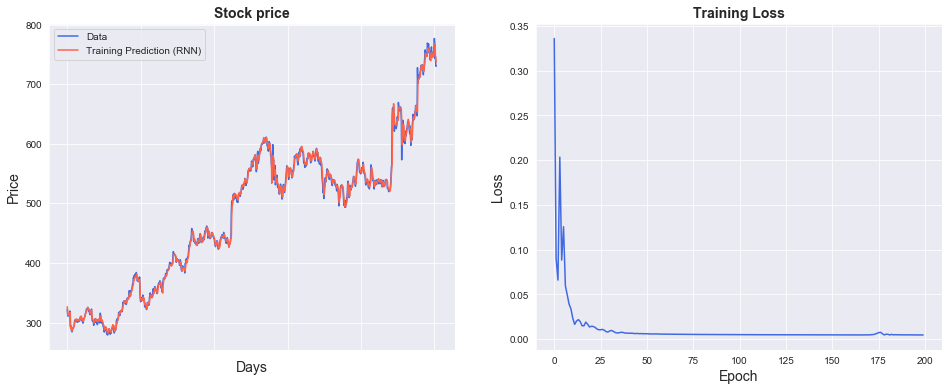

In [48]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (RNN)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [49]:
from sklearn.metrics import mean_squared_error

# make predictions
y_val_pred_rnn = model(x_val)

# invert predictions
y_train_pred_rnn = scaler.inverse_transform(y_train_pred_rnn.detach().numpy())
y_train_rnn = scaler.inverse_transform(y_train_rnn.detach().numpy())

y_val_pred_rnn = scaler.inverse_transform(y_val_pred_rnn.detach().numpy())
y_val_rnn = scaler.inverse_transform(y_val_rnn.detach().numpy())

rnn_train_error_list = [] 
for i in range(5):
    train_error_rnn = (np.square(y_train_rnn[:,i]-y_train_pred_rnn[:,i])).mean()
    train_error_rnn = np.sqrt(train_error_rnn)
    rnn_train_error_list.append(train_error_rnn)


rnn_val_error_list = []    
for i in range(5):
    val_error_rnn = (np.square(y_val_rnn[:,i]-y_val_pred_rnn[:,i])).mean()
    val_error_rnn = np.sqrt(val_error_rnn)
    rnn_val_error_list.append(val_error_rnn)


In [50]:
# make predictions
y_test_pred_rnn = model(x_test)

# invert predictions
y_test_pred_rnn = y_test_pred_rnn.detach().numpy()
y_test_pred_rnn = scaler.inverse_transform(y_test_pred_rnn)

y_test_rnn = y_test_rnn.detach().numpy()
y_test_rnn = scaler.inverse_transform(y_test_rnn)

rnn_test_error_list = []
for i in range(5):
    test_error_rnn = (np.square(y_test_rnn[:,i]-y_test_pred_rnn[:,i])).mean()
    test_error_rnn = np.sqrt(test_error_rnn)
    rnn_test_error_list.append(test_error_rnn)
    
print(rnn_test_error_list)
print(y_test_pred_rnn)

[10.639312, 9.471178, 13.204585, 14.923263, 544269.44]
[[7.8082001e+02 7.8675647e+02 7.7268842e+02 7.9452881e+02 1.3780704e+06]
 [7.7683820e+02 7.8293555e+02 7.6811652e+02 7.8570209e+02 2.0420046e+06]
 [7.7763617e+02 7.8472662e+02 7.6927728e+02 7.9485583e+02 1.8472554e+06]
 [7.8199414e+02 7.8901703e+02 7.7430109e+02 7.9998761e+02 1.6415736e+06]
 [7.8409668e+02 7.9142065e+02 7.7673737e+02 8.0369019e+02 1.7636701e+06]
 [7.9115076e+02 7.9817133e+02 7.8388916e+02 8.1676910e+02 1.8931264e+06]
 [7.9764539e+02 8.0540411e+02 7.9040271e+02 8.2139758e+02 1.6987009e+06]
 [7.9980750e+02 8.0665802e+02 7.9248865e+02 8.1845160e+02 1.6454671e+06]
 [7.9943512e+02 8.0552338e+02 7.9179871e+02 8.1948657e+02 1.6020229e+06]
 [7.9899908e+02 8.0561804e+02 7.9089600e+02 8.1938751e+02 1.8281936e+06]
 [8.0081464e+02 8.0795728e+02 7.9282880e+02 8.2200342e+02 1.6459716e+06]
 [7.9985583e+02 8.0637793e+02 7.9196991e+02 8.1783838e+02 1.8185359e+06]
 [7.9866858e+02 8.0504919e+02 7.9046631e+02 8.1837769e+02 1.7219441e+

In [51]:
Error_test_pct_list_rnn = []

for i in range(5):
    Error_test_pct_rnn = abs(y_test_rnn[:,i] - y_test_pred_rnn[:,i])
    Error_test_pct_rnn = np.mean(Error_test_pct_rnn)
    Error_test_pct_rnn = Error_test_pct_rnn/(y_test_pred_rnn[:,i].mean())
    Error_test_pct_list_rnn.append(Error_test_pct_rnn)

print('Vanilla RNN test - (MAPE):', Error_test_pct_list_rnn)     

Vanilla RNN test - (MAPE): [0.011714887, 0.00951913, 0.0153730335, 0.014931532, 0.25720647]


### Model Comparison

#### Train error comparison

In [52]:
gru_train_error_list = [round(num, 3) for num in gru_train_error_list]
gru_train_error_list = pd.DataFrame(gru_train_error_list, columns=['gru'])

lstm_train_error_list = [round(num, 3) for num in lstm_train_error_list]
lstm_train_error_list = pd.DataFrame(lstm_train_error_list, columns=['lstm'])

rnn_train_error_list = [round(num, 3) for num in rnn_train_error_list]
rnn_train_error_list = pd.DataFrame(rnn_train_error_list, columns=['rnn'])

train_error = pd.concat([gru_train_error_list, lstm_train_error_list, rnn_train_error_list], axis=1)
train_error.rename({0: 'open', 1: 'high', 2:'low', 3:'close', 4:'volume'}, axis='index')

,gru,lstm,rnn
open,6.645000e+00,7.280,7.193
high,7.593000e+00,8.158,7.949
low,7.436000e+00,8.134,8.023
close,2.134200e+01,22.227,22.094
volume,1.652218e+06,1716789.749,1653753.000


(0, 50)

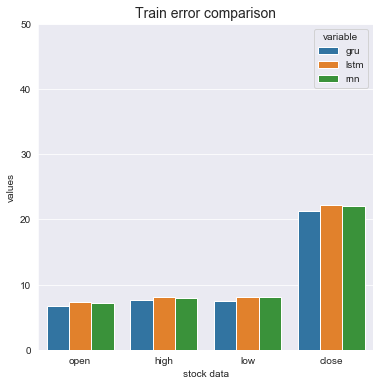

In [53]:
train_error = train_error.iloc[:4,:]
train_error.index  = ["open", "high", "low", 'close']
df_plot = train_error.reset_index().rename({'index': 'stock data'}, axis=1)
df_plot = df_plot.melt(id_vars='stock data')

fig,ax = plt.subplots(figsize=(6,6))
sns.barplot('stock data', 'value', hue='variable', data=df_plot, ax=ax)
plt.title('Train error comparison', fontsize= 14)
plt.xlabel('stock data')
plt.ylabel('values')
plt.ylim(0,50)

#### Validation error comparison

In [54]:
lstm_val_error_list = [round(num, 3) for num in lstm_val_error_list]
lstm_val_error_list = pd.DataFrame(lstm_val_error_list, columns=['lstm'])

gru_val_error_list = [round(num, 3) for num in gru_val_error_list]
gru_val_error_list = pd.DataFrame(gru_val_error_list, columns=['gru'])

rnn_val_error_list = [round(num, 3) for num in rnn_val_error_list]
rnn_val_error_list = pd.DataFrame(rnn_val_error_list, columns=['rnn'])

val_error = pd.concat([gru_val_error_list, lstm_val_error_list, rnn_val_error_list], axis=1)
val_error.rename({0: 'open', 1: 'high', 2:'low', 3:'close', 4:'volume'}, axis='index')


,gru,lstm,rnn
open,8.106,8.495,9.057
high,8.539,9.007,8.880
low,10.461,10.644,11.409
close,9.863,10.544,13.144
volume,705561.750,762991.927,701221.250


(0, 50)

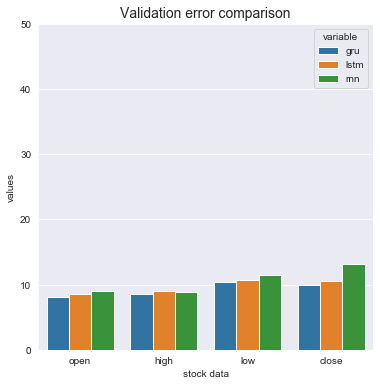

In [55]:
val_error = val_error.iloc[:4,:]
val_error.index  = ["open", "high", "low", 'close']
df_plot = val_error.reset_index().rename({'index': 'stock data'}, axis=1)
df_plot = df_plot.melt(id_vars='stock data')

fig,ax = plt.subplots(figsize=(6,6))
sns.barplot('stock data', 'value', hue='variable', data=df_plot, ax=ax)
plt.title('Validation error comparison', fontsize= 14)
plt.xlabel('stock data')
plt.ylabel('values')
plt.ylim(0,50)

#### Test error comparison


In [56]:
lstm_test_error_list = [round(num, 3) for num in lstm_test_error_list]
lstm_test_error_list = pd.DataFrame(lstm_test_error_list, columns=['lstm'])

gru_test_error_list = [round(num, 3) for num in gru_test_error_list]
gru_test_error_list = pd.DataFrame(gru_test_error_list, columns=['gru'])

rnn_test_error_list = [round(num, 3) for num in rnn_test_error_list]
rnn_test_error_list = pd.DataFrame(rnn_test_error_list, columns=['rnn'])

test_error = pd.concat([gru_test_error_list, lstm_test_error_list, rnn_test_error_list], axis=1)
test_error.rename({0: 'open', 1: 'high', 2:'low', 3:'close', 4:'volume'}, axis='index')

,gru,lstm,rnn
open,7.584,6.906,10.6390
high,7.907,8.216,9.4710
low,11.036,9.267,13.2050
close,8.755,10.335,14.9230
volume,567963.250,619399.869,544269.4375


(0, 50)

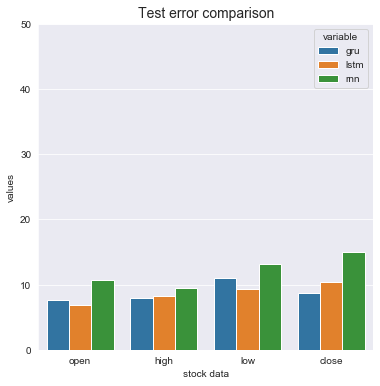

In [57]:
test_error = test_error.iloc[:4,:]
test_error.index  = ["open", "high", "low", 'close']
df_plot = test_error.reset_index().rename({'index': 'stock data'}, axis=1)
df_plot = df_plot.melt(id_vars='stock data')

fig,ax = plt.subplots(figsize=(6,6))
sns.barplot('stock data', 'value', hue='variable', data=df_plot, ax=ax)
plt.title('Test error comparison', fontsize= 14)
plt.xlabel('stock data')
plt.ylabel('values')
plt.ylim(0,50)

#### Comparision of predicted vs actual value

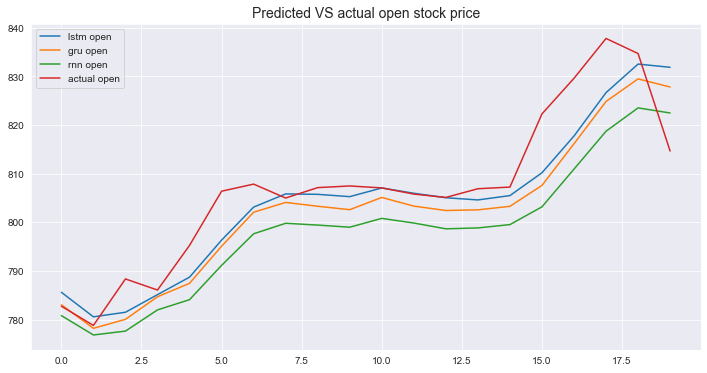

In [58]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,0], label='lstm open');
plt.plot(y_test_pred_gru[:,0], label='gru open');
plt.plot(y_test_pred_rnn[:,0], label='rnn open');
plt.plot(y_test_lstm[:,0], label='actual open');
plt.title('Predicted VS actual open stock price', fontsize=14)
plt.legend()

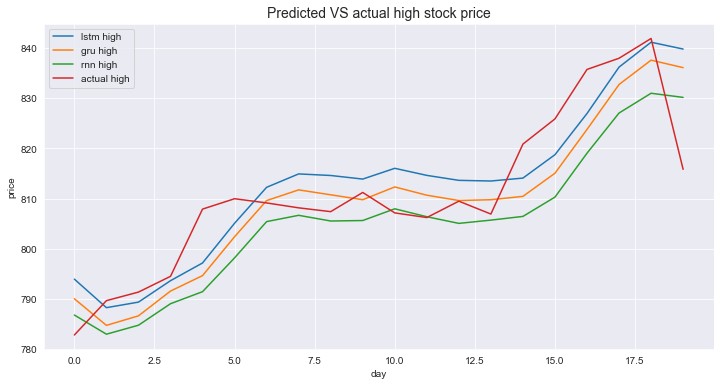

In [59]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,1], label='lstm high');
plt.plot(y_test_pred_gru[:,1], label='gru high');
plt.plot(y_test_pred_rnn[:,1], label='rnn high');
plt.plot(y_test_lstm[:,1], label='actual high');
plt.title('Predicted VS actual high stock price', fontsize=14)
plt.xlabel('day')
plt.ylabel('price')
plt.legend()

In [60]:
y_test_pred_lstm.shape

(20, 5)

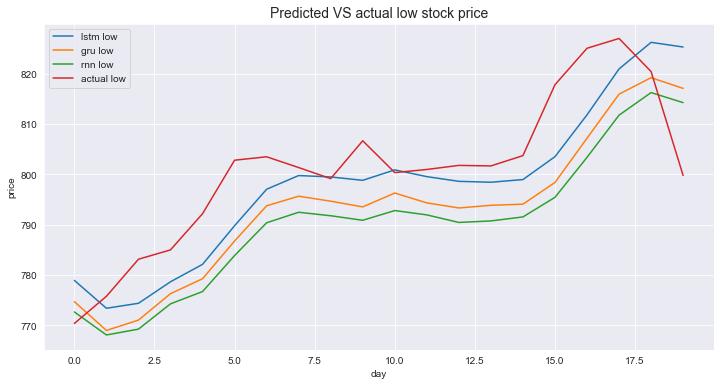

In [61]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,2], label='lstm low');
plt.plot(y_test_pred_gru[:,2], label='gru low');
plt.plot(y_test_pred_rnn[:,2], label='rnn low');
plt.plot(y_test_lstm[:,2], label='actual low');
plt.title('Predicted VS actual low stock price', fontsize=14)
plt.xlabel('day')
plt.ylabel('price')
plt.legend()

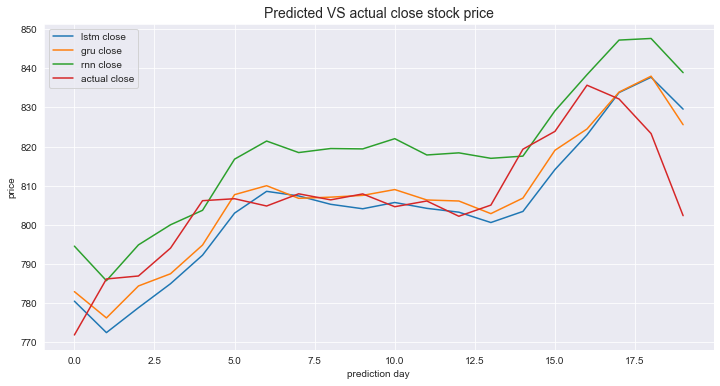

In [62]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,3], label='lstm close');
plt.plot(y_test_pred_gru[:,3], label='gru close');
plt.plot(y_test_pred_rnn[:,3], label='rnn close');
plt.plot(y_test_lstm[:,3], label='actual close');
plt.title('Predicted VS actual close stock price', fontsize=14)
plt.xlabel('prediction day')
plt.ylabel('price')
plt.legend()

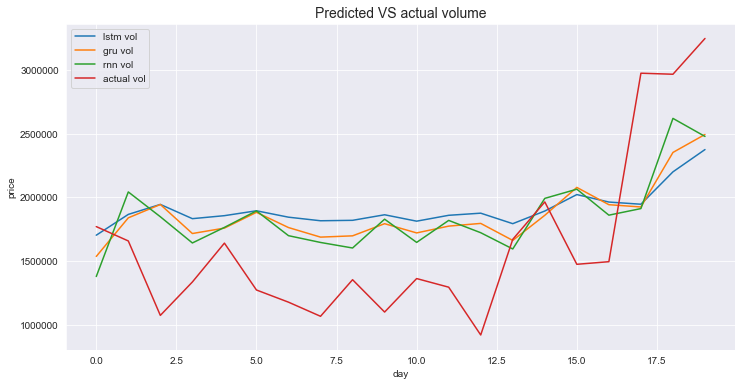

In [63]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,4], label='lstm vol');
plt.plot(y_test_pred_gru[:,4], label='gru vol');
plt.plot(y_test_pred_rnn[:,4], label='rnn vol');
plt.plot(y_test_lstm[:,4], label='actual vol');
plt.title('Predicted VS actual volume', fontsize=14)
plt.xlabel('day')
plt.ylabel('price')
plt.legend()